In [159]:
#1.1 Initial datapoints
#1.2 Momentum factors, CPI/PPI Calculations, modified timeframe.
#1.3 Doing grid search on the depth parameter, and sub space sampling

In [ ]:
#derived from statsmodel tutorial https://www.statsmodels.org/stable/vector_ar.html

In [160]:
#Imports and API Key

import pandas as pd
import quandl
from scipy import stats
import scipy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer

import statsmodels.api as sm

from statsmodels.tsa.api import VAR, DynamicVAR

from fbprophet import Prophet

%aimport dataclean

quandl.ApiConfig.api_key = 'm8FYMyoCaJSbTrBASNHh'

In [161]:
#pulling data from Quandl

data = pd.read_csv('datasources2.csv') #staging the QUANDL keys to pull in CSV
cols = list(data['Var_name'].astype('str'))
dataset = quandl.get([val for val in data['Quandl Key']]) #looping through the QUANDL keys to pull it into one DF
dataset.columns = cols

In [162]:
#pulling FED Yield Curve data

yields = pd.read_csv('Fed10Y_3M.csv')
yields['Date'] = pd.to_datetime(yields['Date'])
yields['Date'] = yields['Date'].apply(lambda x: x.strftime('%Y-%m'))
yields = yields.set_index('Date')
yields = yields.drop(['3 Month Treasury Yield', 'Rec_prob', 'NBER_Rec','Unnamed: 7'], axis=1) 

In [163]:
## back to working on the general data
dataset.index = dataset.index.strftime('%Y-%m') #converting the datetime index to Y/M so it is collapsable
dataset = dataset.groupby(dataset.index, as_index=True).agg(sum) #collapsing by Y/M

In [164]:
#converting GDP quarterly data into monthly

dataset = dataclean.convert_q_to_m(dataset, 'GDP')

#converting consumer sentiment into monthly

dataset = dataclean.convert_q_to_m(dataset, 'CONS_SENT')

In [165]:
#offsetting columns to align with time
offset_dict = {'PMI':1, 'UNR':1, 'YUNR':1,'US_NHOME_SALES':1, 'PART_TIME':1, 'CPPR_PRICE':1, 'HOUS_PERMS':1, 'HOUS_STARTS':1, 'CAP_UTIL':1, 'PERS_SAVINGS':3, 'EXPORTS':3, 'IMPORTS':3, 'TRADE_BALANCE':3, 'US_M2':1, 'US_NHOME_SALES':1,'PPI':1,'CPI':1} #positives shift down, negatives shift up. Goal of this dict is to align data to when it gets released

for entry in offset_dict:
    #print(entry)
    #print(offset_dict[entry])
    dataset[str(entry)] = dataset[str(entry)].shift(offset_dict[entry])

In [166]:
#merge fed interest rate data here
dataset = dataset.join(yields, how='outer')

In [167]:
#cutoff most of missing data, Post March 2019, Prior 1959. CPI/PPI missing 2016 onward so need to cut that off
dataset = dataset.iloc[552:]
dataset = dataset.iloc[:-59]

In [168]:
#substituting mean value in for missing values and adding dummy column to indicate where done

for col in dataset.columns:
    dataclean.clean_zeros(col, dataset)

In [170]:
#adding momentum factors

momentum_cols = list(dataset.columns[:-6])

momentum_cols.remove('PPI') #removing PPI and CPI because they need a different transformation
momentum_cols.remove('CPI')
#momentum_cols.remove('Recession')

for i in [1,3,12]:
    for col in momentum_cols:
        if 'PXY' in str(col): #adding logic so it doesn't create a momentum column out of PXY columns
            continue
        dataclean.create_momentum(col,dataset,i)

In [171]:
#CPI Calcs

for i in [1,3,12]:
    for col in ['CPI','PPI']:
        dataclean.infl_momentum(col,dataset,i)

In [172]:
### Data Prep Finished Here ###

In [173]:
dataset = dataset.iloc[12:]

In [180]:
dataset

,PMI,UNR,YUNR,CONS_SENT,PART_TIME,CPPR_PRICE,HOUS_PERMS,HOUS_STARTS,CAP_UTIL,PERS_SAVINGS,...,GDP_12m_shift,10 Year Treasury Yield_12m_shift,3 Month Treasury Yield (Bond Equivalent Basis)_12m_shift,Spread_12m_shift,CPI_1m_shift,PPI_1m_shift,CPI_3m_shift,PPI_3m_shift,CPI_12m_shift,PPI_12m_shift
1960-01,58.200,5.300,11.100,93.800,1000.000,151.480,1336.630,1601.000,68.973,9.400,...,153.821,0.700,1.580,-0.880,0.000,0.000,0.341,-0.631,1.730,-0.316
1960-02,61.500,5.200,10.900,93.800,1015.000,151.480,1092.000,1460.000,68.973,10.100,...,153.821,0.530,1.300,-0.770,-0.340,0.317,-0.340,0.000,1.034,-0.315
1960-03,52.300,4.800,10.200,93.800,1062.000,151.480,1088.000,1503.000,68.973,11.000,...,153.821,0.260,0.520,-0.260,0.341,0.000,0.000,0.317,1.730,-0.315
1960-04,47.800,5.400,11.500,93.800,888.000,151.480,955.000,1109.000,68.973,10.900,...,65.708,0.160,0.290,-0.130,0.000,0.633,0.000,0.952,1.730,0.315
1960-05,45.300,5.200,10.900,93.300,1041.000,151.480,1016.000,1289.000,68.973,10.600,...,65.708,0.040,0.460,-0.420,0.340,0.000,0.683,0.633,1.724,0.000
1960-06,42.600,5.100,10.700,93.300,988.000,151.480,1052.000,1271.000,68.973,9.400,...,65.708,-0.190,-0.770,0.580,0.000,-0.314,0.340,0.316,1.724,-0.314
1960-07,44.400,5.400,11.000,93.300,966.000,151.480,958.000,1247.000,68.973,8.400,...,79.376,-0.500,-0.920,0.420,0.339,0.000,0.680,-0.314,1.718,0.000
1960-08,43.700,5.500,10.800,97.200,1013.000,151.480,999.000,1197.000,68.973,10.400,...,79.376,-0.630,-1.110,0.480,0.000,0.000,0.339,-0.314,1.370,0.000
1960-09,47.600,5.600,11.400,97.200,1018.000,151.480,994.000,1344.000,68.973,10.400,...,79.376,-0.880,-1.610,0.730,0.000,-0.315,0.339,-0.315,1.370,0.000
1960-10,45.400,5.500,11.000,97.200,1027.000,151.480,984.000,1097.000,68.973,10.400,...,28.250,-0.640,-1.800,1.160,0.000,0.000,0.000,-0.315,1.024,-0.315


In [186]:
train_data = dataset[['PMI','UNR','YUNR','HOUS_PERMS','GDP']]

In [192]:
train_data = train_data[:550]

In [193]:
model = VAR(train_data)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [200]:
results = model.fit(30)

In [201]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, Apr, 2019
Time:                     15:15:39
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    17.7391
Nobs:                     520.000    HQIC:                   13.9824
Log likelihood:          -5940.59    FPE:                    114566.
AIC:                      11.5629    Det(Omega_mle):         32022.8
--------------------------------------------------------------------
Results for equation PMI
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  3.132022         3.396488            0.922           0.356
L1.PMI                 0.876398         0.054181           16.175           0.000
L1.UNR                -1.172887         1.070802          

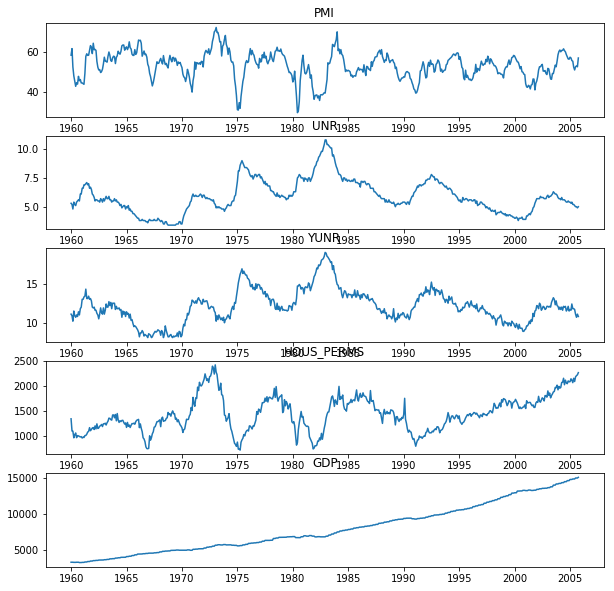

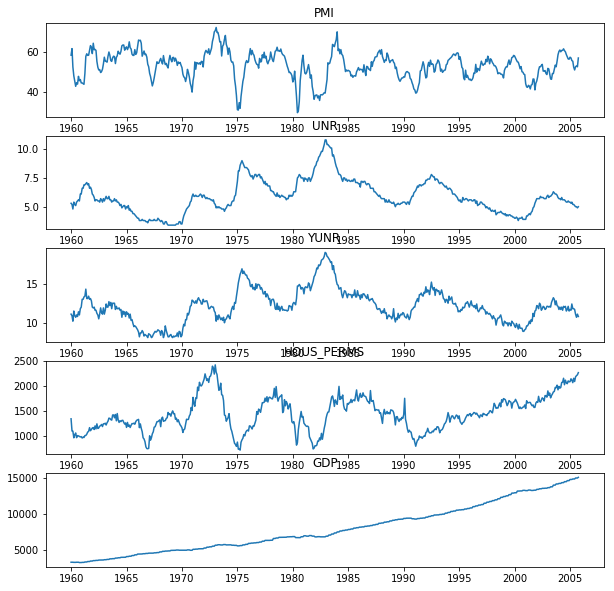

In [202]:
results.plot()

In [203]:
lag_order = results.k_ar

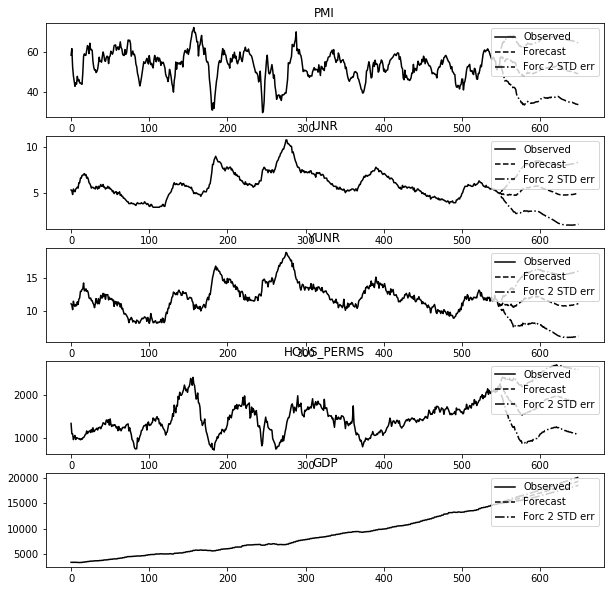

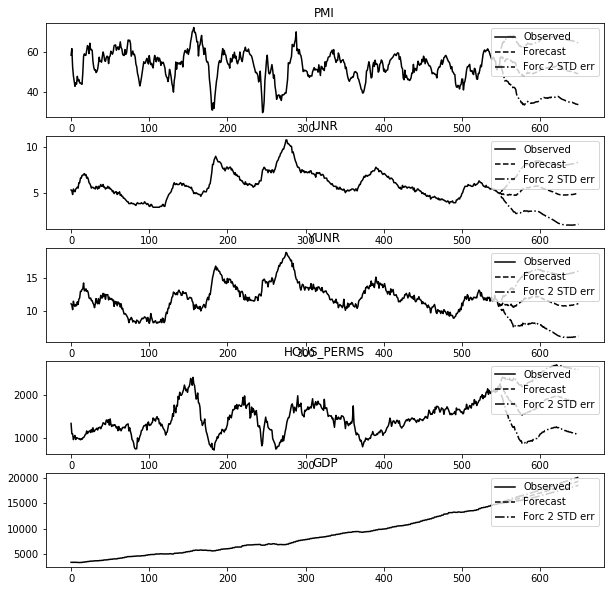

In [204]:
results.plot_forecast(100)